### Setup

In [1]:
%load_ext autoreload
%autoreload --print 3

In [6]:
import jax.random as jr
jr.KeyArray = jr.PRNGKey
import shape_norm

from shape_norm.io import loaders
from shape_norm.models import joint
from shape_norm import config
from shape_norm.models import instantiation, setup, pose, morph, util as model_util
from shape_norm import fitting
from shape_norm.fitting import em
from shape_norm.io import alignment, features
from shape_norm.io.armature import Armature
from shape_norm.fitting import methods
from shape_norm.fitting import scans
from shape_norm.pca import fit_with_center, CenteredPCA, PCAData
from shape_norm.io.dataset import PytreeDataset
from shape_norm.io.dataset_refactor import Dataset, SessionMetadata
from shape_norm.models.morph.lowrank_affine import LRAParams, model as lra_model
from shape_norm.viz import styles

from blscale_loader import loader, linear_skeletal as blscale_ls

from collections import defaultdict
from shape_norm.viz import util as vu
from scipy import spatial
import itertools as iit
import numpy as np
import re
import jax
import jax.numpy as jnp
from pprint import pprint
from ruamel.yaml import YAML
import numpy.linalg as la
import scipy.stats
from pathlib import Path
import matplotlib as mpl
import joblib as jl
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import itertools as iit
import pandas as pd
import seaborn as sns


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plot_dir = '/Users/kaifox/projects/mph/data_explore/plots/notebook/panels/v5/f1.3_supervised'
params_file = "/Users/kaifox/projects/mph/generative_api/test/notebooks/panels/plot_params.yml"

plot_meta = YAML(typ='safe').load(open(params_file, 'r'))
colors, plotter = styles.init_plt(plot_dir, style='default', fmt = 'pdf', **plot_meta['savefig'])
plt.rcParams.update(plot_meta['rc'])
plot_root = Path(plotter.plot_dir)

### Supporting functions

#### Raw keypoint data supporting funcs

In [7]:
def raw_data_armature_meta():
    """Organize metadata on keypoints and skeleton of mouse data."""
    names = [
        'shldr', 'back', 'hips', 't_base', 't_tip', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot']
    parents = dict(zip(names, [
        'back', 'hips', None, 'hips', 't_base', 'shldr',
        'head', 'head', 'head', 'hips', 'lr_knee',
        'hips', 'rr_knee', 'shldr', 'shldr']))
    keypt_ix = lambda name: names.index(name)
    bones = np.array([(keypt_ix(c), keypt_ix(p)) for c, p in parents.items() if p])
    root = keypt_ix("shldr")
    bones = blscale_ls.reroot(bones, root)
    bones = bones[np.argsort(bones[:, 0])]
    return names, parents, bones, root

def raw_data_armature_meta_no_tail():
    """Organize metadata on keypoints and skeleton of mouse data."""
    names = [
        'shldr', 'back', 'hips', 't_base', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot']
    parents = dict(zip(names, [
        'back', 'hips', None, 'hips', 'shldr',
        'head', 'head', 'head', 'hips', 'lr_knee',
        'hips', 'rr_knee', 'shldr', 'shldr']))
    keypt_ix = lambda name: names.index(name)
    bones = np.array([(keypt_ix(c), keypt_ix(p)) for c, p in parents.items() if p])
    root = keypt_ix("shldr")
    bones = blscale_ls.reroot(bones, root)
    bones = bones[np.argsort(bones[:, 0])]
    return names, parents, bones, root

keypt_names = [
    'shldr',
    'back',
    'hips',
    't_base',
    'head',
    'l_ear',
    'r_ear',
    'nose',
    'lr_knee',
    'lr_foot',
    'rr_knee',
    'rr_foot',
    'lf_foot',
    'rf_foot'
]
keypt_ix = lambda k: keypt_names.index(k)
_names, _parents, _bones, _root = raw_data_armature_meta_no_tail()
arms = Armature(_names, _bones, _root, anterior=[], posterior=[])

# bone_names = [f'{keypt_names[i]}-{keypt_names[j]}' for i, j in armature.bones]
bone_names = [
    'hi back', #  'back-shldr',
    'lo back', #  'hips-back',
    'rump', #  't_base-hips',
    'neck', #  'head-shldr',
    'left ear', #  'l_ear-head',
    'right ear', #  'r_ear-head',
    'head', #  'nose-head',
    'left hindlimb', #  'lr_knee-hips',
    'left hind foot', #  'lr_foot-lr_knee',
    'right hindlimb', #  'rr_knee-hips',
    'right hind foot', #  'rr_foot-rr_knee',
    'left forelimb', #  'lf_foot-shldr',
    'right forelimb' #  'rf_foot-shldr'
]
keypt_parent = lambda ix, armature = arms: armature.bones[armature.bones[:, 0] == ix, 1][0]
has_parent = lambda ix, armature = arms: np.any(armature.bones[:, 0] == ix)
bone_ix = lambda keypt_ix, armature = arms: np.where(armature.bones[:, 0] == keypt_ix)[0][0]

joints = np.array([(child, parent, keypt_parent(parent)) for child, parent in arms.bones if has_parent(parent)])
joint_names = [f'{keypt_names[c]}-{keypt_names[p]}-{keypt_names[g]}' for c, p, g in joints]
joint_names = [
'back', #  'hips-back-shldr',
'hips', #  't_base-hips-back',
'left ear', #  'l_ear-head-shldr',
'right ear', #  'r_ear-head-shldr',
'head', #  'nose-head-shldr',
'left hindlimb', #  'lr_knee-hips-back',
'left hind foot', #  'lr_foot-lr_knee-hips',
'right hindlimb', #  'rr_knee-hips-back',
'right hind foot', #  'rr_foot-rr_knee-hips'
]

short_names = [keypt_names[i] for i, j in arms.bones]
cos = lambda a, b: np.clip(
    (a * b).sum(axis=-1) / (la.norm(a, axis=-1) * la.norm(b, axis=-1)), -1, 1
)
full_joint_angles_func = (
    lambda kpts, joint_ix, joints: 180
    / np.pi
    * np.arccos(
        np.clip(
            cos(
                kpts[:, joints[joint_ix, 0], :] - kpts[:, joints[joint_ix, 1], :],
                kpts[:, joints[joint_ix, 2], :] - kpts[:, joints[joint_ix, 1], :],
            ),
            -1,
            1,
        )
    )
)
joint_angles = lambda kpts, joint_ix: full_joint_angles_func(kpts, joint_ix, joints)

#### Dataset functions

In [8]:
_with_match = lambda test, pattern, f: f(m) if (m := re.search(pattern, test)) else None
_name_func = lambda path, *a: _with_match(
    path, r"(?:/.*)+/\d{2}_\d{2}_\d{2}_(\d+wk_m\d+)\.npy",
    lambda m: f"{m.group(1)}")

def full_ontogeny_data(data_dir, session_filter=None, ref_session=None):
    _sources = dict(map(lambda x: (_name_func(str(x)),) * 2, data_dir.glob(f"*.npy")))
    if session_filter is not None:
        _sources = {k: v for k, v in _sources.items() if session_filter(k)}
    ont_keypoints, _ = loader.from_sources_dict(
        data_dir,
        _sources,
        extension='.npy',
        name_func=_name_func,
    )
    names, parents, _, _ = raw_data_armature_meta()

    if ref_session is None:
        ref_session = list(ont_keypoints.keys())[0]

    project_config_kws = {
        "session_names": ont_keypoints.keys(),
        "bodies": {s: f'b-{s}' for s in ont_keypoints},
        "ref_session": ref_session,
        "keypoint_names": names,
        "keypoint_parents": parents,
    }

    return project_config_kws, ont_keypoints

def full_ontogeny_data_aligned(data_dir, session_filter=None, use_keypoints=None, scale_ntt=False):
    project_config_kws, ont_keypoints = full_ontogeny_data(data_dir, session_filter)
    if use_keypoints is None:
        use_keypoints = project_config_kws['keypoint_names']
    dataset = loaders.arrays.from_arrays(ont_keypoints, dict(
        type='arrays',
        subsample=None,
        subsample_to=None,
        ref_session=project_config_kws['ref_session'],
        sessions={s: dict(body=b) for s, b in project_config_kws['bodies'].items()},
        keypoint_names=project_config_kws['keypoint_names'],
        use_keypoints=use_keypoints,
        anterior=None,
        posterior=None,
        invert_axes=None,
    ))
    aligned, align_inv = alignment.align(dataset, dict(
        type='sagittal',
        origin='hips',
        anterior='head',
        rescale=scale_ntt,
        rescale_mode='session',
    ))
    return aligned, dataset, align_inv
    

#### Ethogram generation functions

In [10]:
def crossings(x, th_lo, th_hi, min_duration=0):
    above_lo = x > th_lo
    diff = np.diff(np.concatenate(([0], above_lo.astype(int))))
    start_indices = np.where(diff == 1)[0]
    end_indices = np.where(diff == -1)[0]
    above_lo_blocks = zip(start_indices, end_indices)
    valid_crossings = [
        (s, e)
        for s, e in above_lo_blocks
        if (np.any(x[s:e] > th_hi) and e - s >= min_duration)
    ]
    # valid_crossings = above_lo_blocks
    return valid_crossings


def intervals_to_signal(n, intervals):
    y = np.zeros(n).astype(bool)
    for s, e in intervals:
        y[s:e] = True
    return y

def signal_to_intervals(signal, min_duration=1):
    return crossings(signal, 0.5, 0.5, min_duration=min_duration)

def nonoverlapping(intervals, signal):
    """Subset intervals to ones in which signal is off"""
    return [
        (s, e)
        for s, e in intervals
        if not np.any(signal[s:e])
    ]


### Load data

In [9]:
data_dir = "/Users/kaifox/projects/mph/data_explore/data"
ont_dataset, unaligned_dataset, align_inv = full_ontogeny_data_aligned(
    Path(data_dir),
    session_filter = lambda s: re.search(r"(\d+)wk", s).group(1) not in ['9', '12'],
    use_keypoints=[
        'shldr', 'back', 'hips', 't_base', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot'])
obs_keypts = {s: ont_dataset.get_session(s) for s in ont_dataset.sessions}
unaligned = {s: unaligned_dataset.get_session(s) for s in unaligned_dataset.sessions}
sessions = ont_dataset.sessions
src_sess = "24wk_m0"
src_keypts = obs_keypts[src_sess]

Loading keypoints: 100%|███████████████| 36/36 [00:00<00:00, 264.99it/s]


### Rearing

In [12]:
head_ht = src_keypts[:, arms.keypoint_names.index("head"), 2]
head_ht = (head_ht - np.median(head_ht)) / scipy.stats.iqr(head_ht)

th_lo, th_hi = 0.7, 1.2
crossing_signal = intervals_to_signal(len(head_ht), crossings(head_ht, th_lo, th_hi))

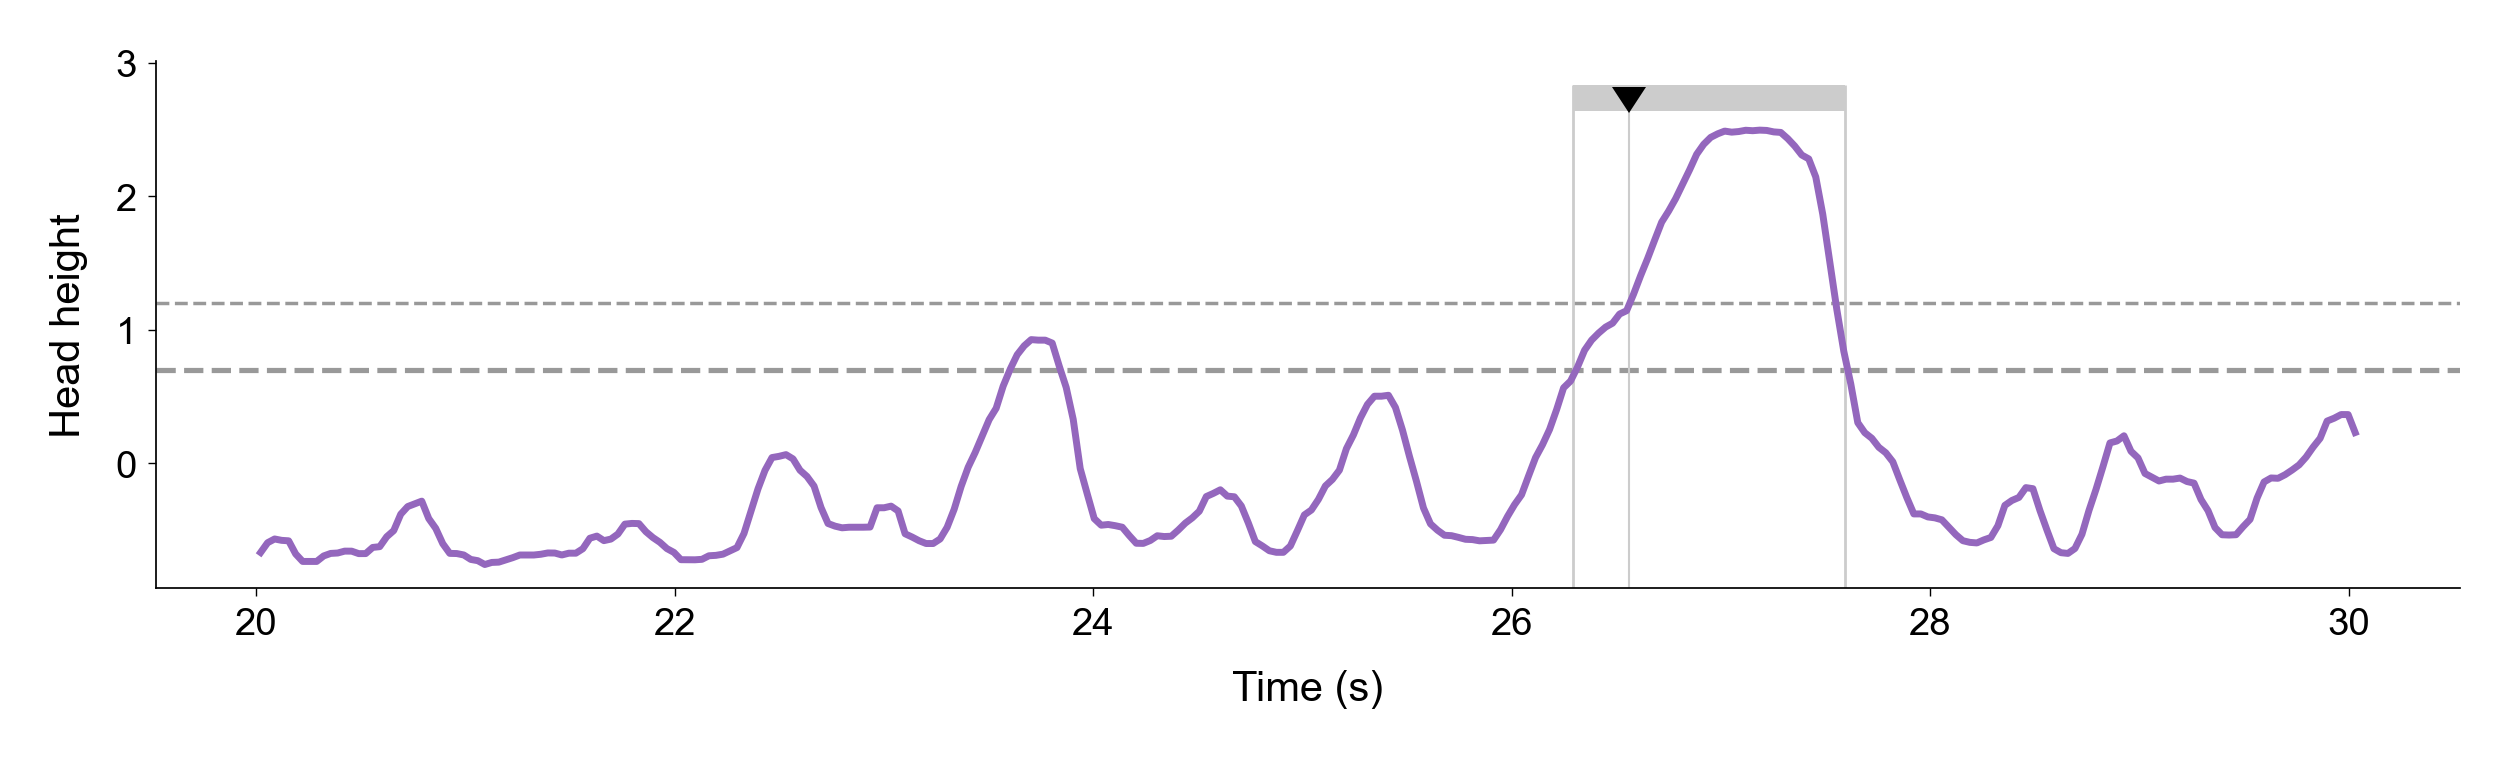

In [70]:
start, stop = 600, 900
fps = 29.97
t_detect = (np.argmax(head_ht[start:stop] > th_hi) + start) / fps
t_on = np.argmax(crossing_signal[start:stop])
t_off = np.argmin(crossing_signal[start+t_on + 1:stop]) + t_on + 1
t_on = (t_on + start) / fps
t_off = (t_off + start) / fps

x = np.linspace(start / fps, stop / fps, stop - start)

fig, ax = plt.subplots(1, 1, figsize = (5, 1.5), dpi = 250)

ax.plot(x, head_ht[start:stop], '-', color = 'C4', lw = 1)
ax.axhline(th_lo, color = '.6', linestyle = '--', lw = 0.75, zorder = -2)
ax.axhline(th_hi, color = '.6', linestyle = '--', lw = 0.5, zorder = -2)
ymin, ymax = head_ht[start:stop].min(), head_ht[start:stop].max()
buf = (ymax - ymin) * 0.1
ax.set_clip_on(False)
ax.plot(t_detect, ymax + buf, marker = 11, color = 'k', ms = 5, mew=0)
ax.fill_between([t_on, t_off], [ymax + buf - 0.18] * 2, [ymax + buf + 0.01] * 2, color = '.8', zorder = -2, lw = 0)
vmin, vmax = ax.get_ylim()
ax.set_ylim(vmin, vmax)
ax.plot([t_on] * 2, [vmin, ymax + buf + 0.01], color = '.8', lw = 0.4, zorder = -2, solid_capstyle = 'butt')
ax.plot([t_off] * 2, [vmin, ymax + buf + 0.01], color = '.8', lw = 0.4, zorder = -2, solid_capstyle = 'butt')
ax.plot([t_detect] * 2, [vmin, ymax + buf + 0.01], color = '.8', lw = 0.3, zorder = -2, solid_capstyle = 'butt')
ax.set_ylabel("Head height")
ax.set_xlabel("Time (s)")

plotter.finalize(fig, None)

#### Head raise

In [ ]:
head_ht = src_keypts[:, arms.keypoint_names.index('head'), 2]
head_ht = (head_ht - np.median(head_ht)) / scipy.stats.iqr(head_ht)

th_hi = (0.7, 1.2)
th_lo = (0.3, 0.8)
crossing_hi = intervals_to_signal(len(head_ht), crossings(head_ht, *th_hi))
intervals_lo = nonoverlapping(crossings(head_ht, *th_lo), crossing_hi)
crossing_lo = intervals_to_signal(len(head_ht), intervals_lo)
